# Init

## Imports

In [1]:
from vpython import *
import numpy as np
import pandas as pd

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Set Up

In [2]:
# Definition of parameters
rM0 = 4.6    # in units of R0
vM0 = 0.51   # in units of R0/T0
aM  = 1.01   # in units of R0/T0**2
TM  = 88.    # in units of T0
rS  = 3.e-7  # in units of R0
c   = 2592.0 # in units of R0/T0
h   = (rM0*vM0/c)**2

print( "h/rM0**2 = {0:1.1e}".format(h/rM0**2))
print( "rS/rM0 = {0:1.1e}".format(rS/rM0))
print( h)

# Initialize distance and velocity vectors
vec_rM0 = vector(0, rM0, 0)
vec_vM0 = vector(vM0, 0, 0)

# Definition of the time step
dt0    = 2. * vM0 / aM
alpha0 = 0. 
beta0  = 0.

# Define the function
def evolve_mercury(vec_rM_old, vec_vM_old, dt=dt0, alpha=alpha0, beta=beta0):
    # Compute the strength of the acceleration      
    aMS = aM * ( 1. + alpha * rS / vec_rM_old.mag + beta * h / vec_rM_old.mag **2  ) / vec_rM_old.mag**2
    # Multiply by the direction
    vec_aMS = - aMS * ( vec_rM_old / vec_rM_old.mag )
    # Update velocity vector
    vec_vM_new = vec_vM_old + vec_aMS * dt
    # Update position vector
    vec_rM_new = vec_rM_old + vec_vM_new * dt
    return vec_rM_new, vec_vM_new

# define function for angle extraction
def angle_between(v1, v2):
    return acos( dot(v1, v2) / (v1.mag * v2.mag) ) * 180. / pi

def get_delta_Theta(dt, alpha=0.0, beta=0.0):
    # Run parameters
    vec_r_last = vec_rM0
    turns      = 0
    max_turns  = 10
    list_perih = list()
    list_angle = list()
    sum_angle  = 0.
    
    # define the initial coordinates; M = mercury, S = sun
    Mpos = vec_rM0
    Mvel = vec_vM0

    # find perihelion for each turn an print it out
    while turns <= max_turns:
        vec_r_before_last = vec_r_last
        vec_r_last        = vector(Mpos)
        # update the velocity and position
        Mpos , Mvel = evolve_mercury(Mpos , Mvel , dt=dt, alpha=alpha, beta=beta)
        # check if at perihelion
        if vec_r_before_last.mag > vec_r_last.mag < Mpos.mag:
            turns = turns+1
            list_perih.append(vec_r_last)
            if turns > 1:
                # draw location of perihelion
                sphere(color=color.green, radius=0.2, pos=vec_r_last)
                # display intermediate results
                list_angle.append(angle_between(list_perih[-2],list_perih[-1]))
                #print("turn: n={n}, perihilion growth: delta Theta={angle}".format(
                #    n=turns, angle=list_angle[-1]
                #))
                # note that list_perih[-2] acces the second last and
                #  list_perih[-1] the last element in the list
    avg_angle=np.sum(list_angle)/len(list_angle)

    # display the average
    #print("--------------------------------")
    #print("average perihilion growth: delta Theta={avg}".format(avg=avg_angle))
    return np.array(list_angle)

h/rM0**2 = 3.9e-08
rS/rM0 = 6.5e-08
8.191926011659805e-07


# Farming

In [5]:
dt_steps = [dt0/n for n in [1,10,100]]
alphas   = np.linspace(1.e5, 1.e6, 10)
alphas   = np.insert(alphas, [0], [0])

data = list()

alpha = 0.0

for dt in dt_steps:
    for par in alphas:
        for alpha, beta in [(0.0, par),(par, 0.0)]:
            angles = get_delta_Theta(dt, alpha=alpha, beta=beta)
            data.append({
                "dt": dt,
                "alpha": alpha,
                "beta": beta,
                "avg": np.average(angles), 
                "std": np.std(angles),
                "angles": angles,
            })

df = pd.DataFrame(data)
df.drop(index=0, axis=1, inplace=True)
df.head()

,alpha,angles,avg,beta,dt,std
1,0.0,"[3.98131657639, 2.53329459971, 3.98141984663, ...",3.257431,0.0,1.009901,0.724031
2,0.0,"[0.428634879754, 0.4287474854, 0.42880269591, ...",0.994652,100000.0,1.009901,1.697862
3,100000.0,"[3.06014945396, 3.45912357982, 3.06018635931, ...",3.259582,0.0,1.009901,0.199465
4,0.0,"[3.40161728438, 3.11806125682, 3.11834863244, ...",3.203223,200000.0,1.009901,0.129885
5,200000.0,"[2.2585123159, 4.26534377924, 2.25833404896, 4...",3.261855,0.0,1.009901,1.003416


# Plotting

In [3]:
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
import re
import pandas as pd
import numpy as np

font="Times"
sns.set(
    style="ticks", 
    font_scale=0.8,
)

matplotlib.rcParams['mathtext.fontset'] = 'cm'
font = {'family':'serif', 'serif': ['times new roman'], 'style': 'normal', 'variant': 'normal', 'weight': 'ultralight'}
plt.rc('font',**font)

cm2inch = lambda cm: cm/2.54

a4w = cm2inch(210./10) #mm
a4h = cm2inch(297./10) #mm

## Linear Interpolation

In [4]:
df = pd.read_csv("mercury_orbit_analysis.csv")

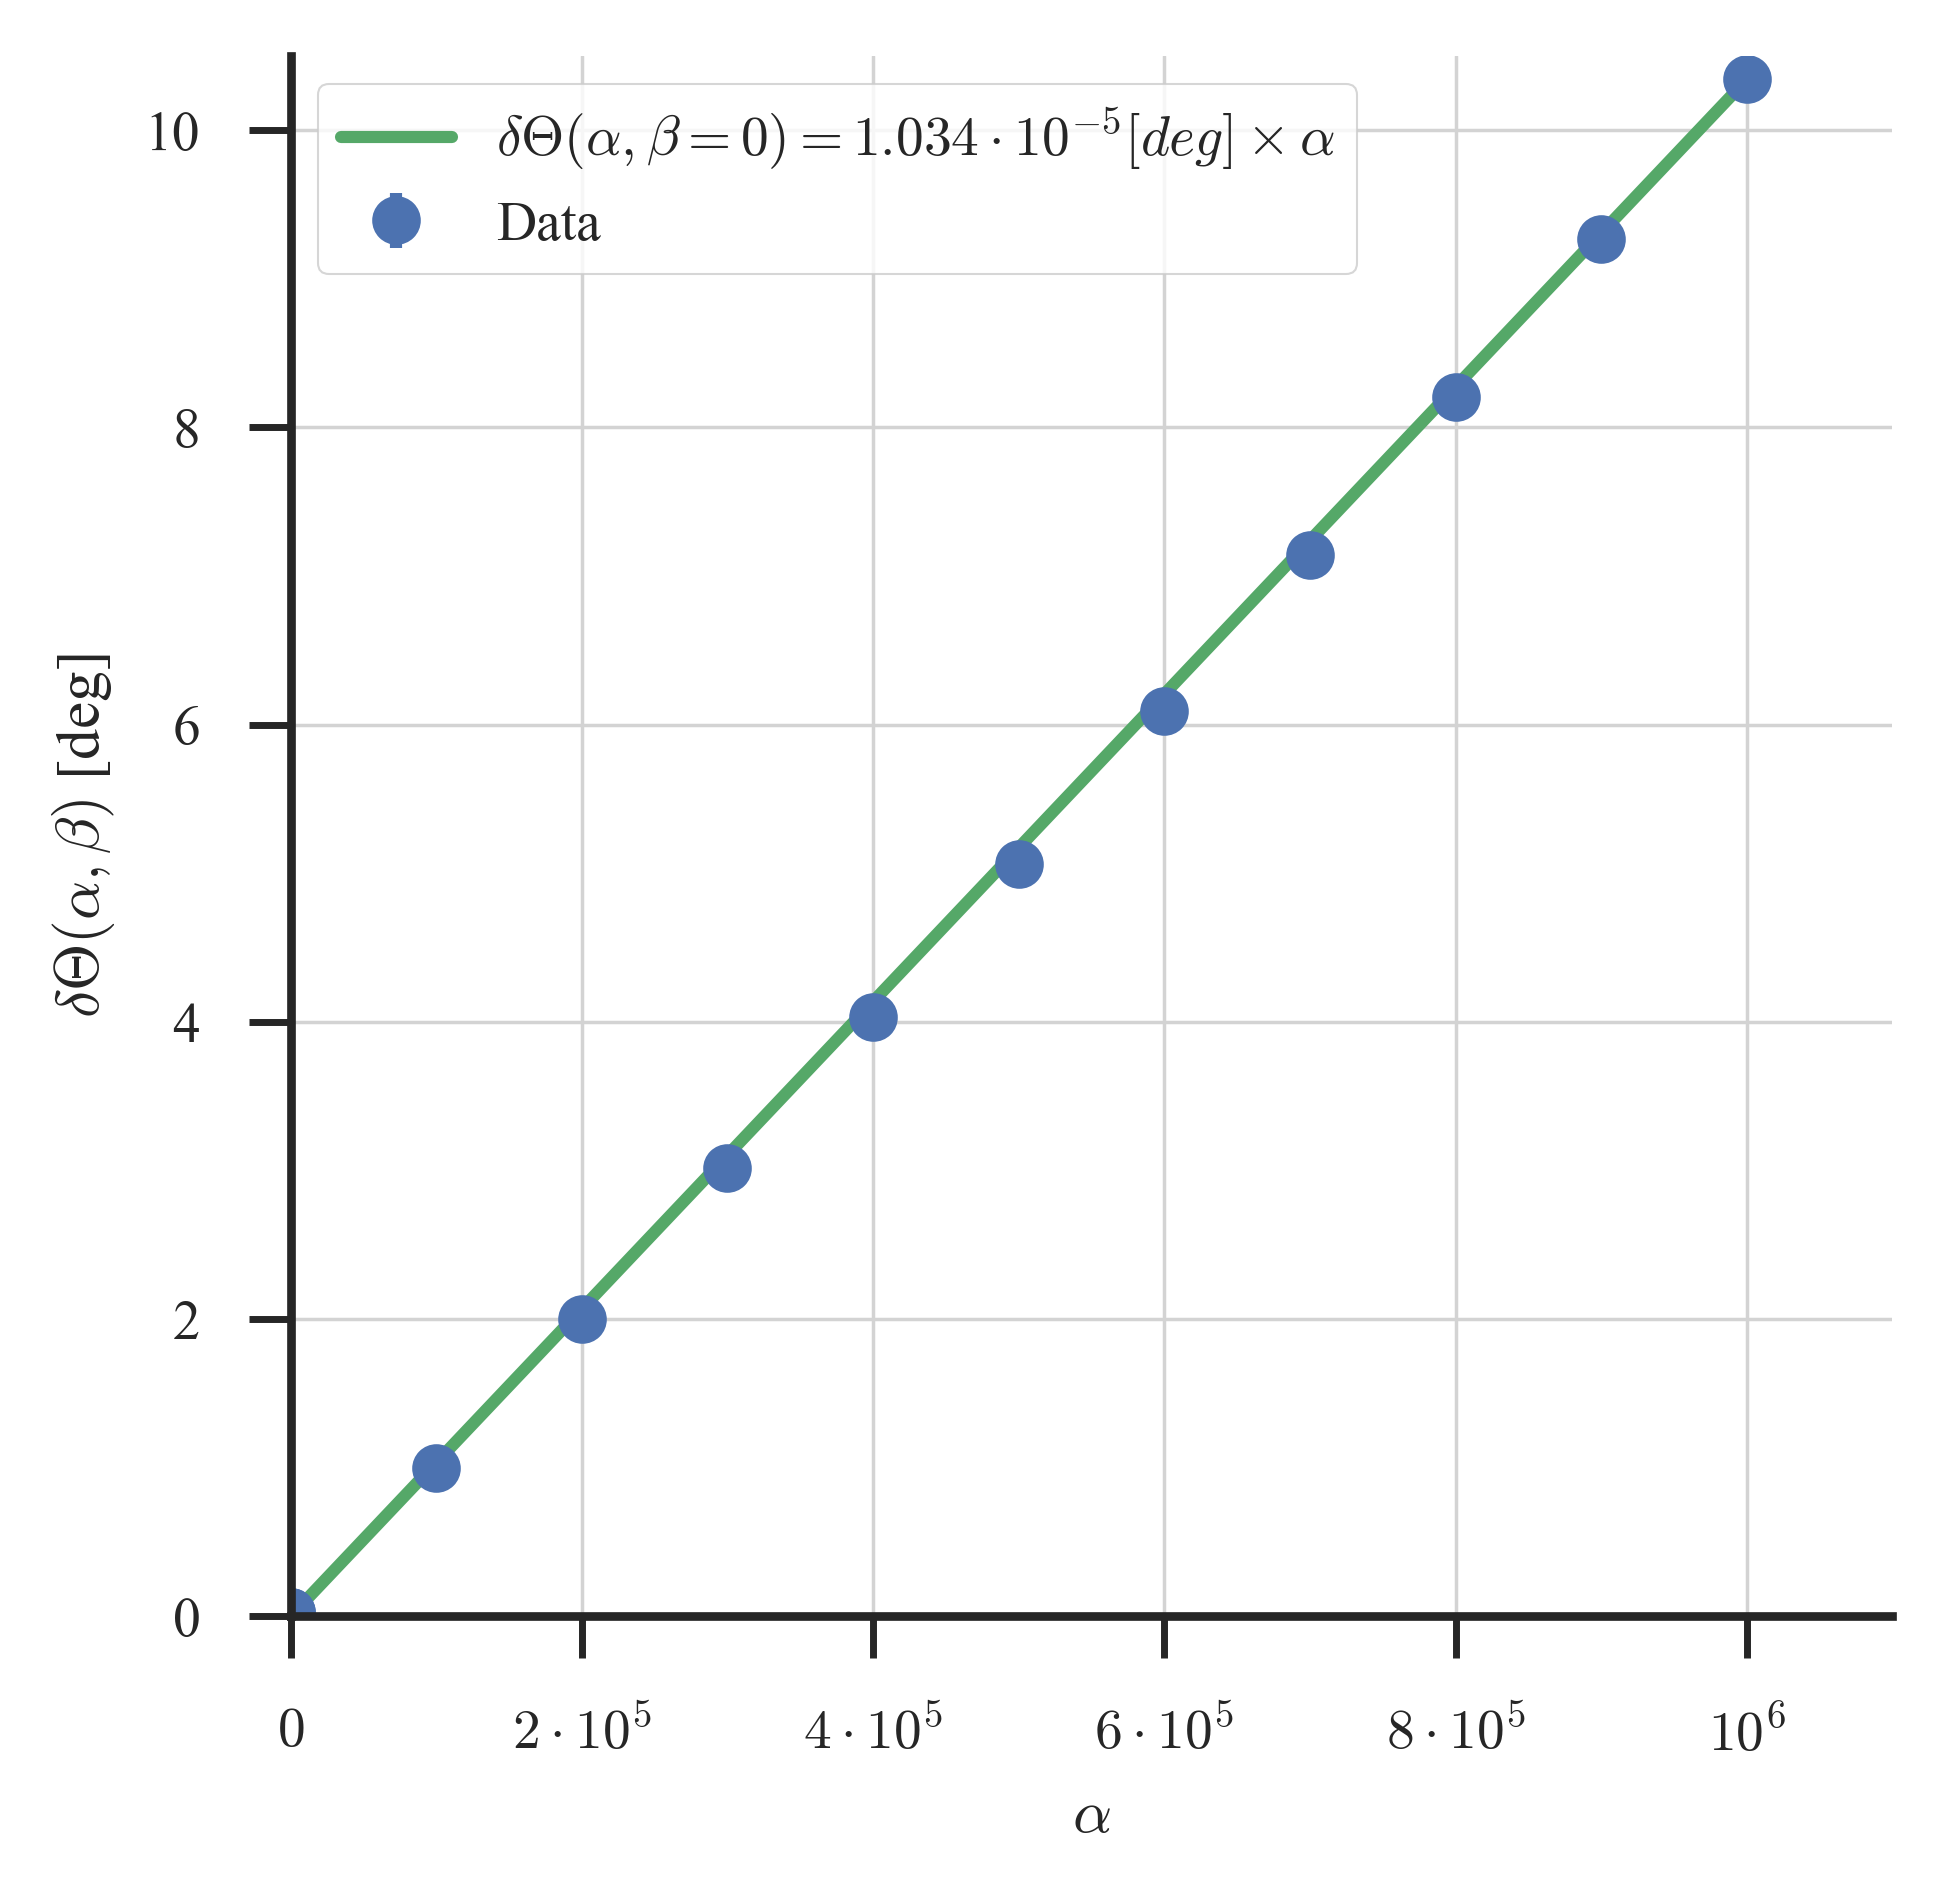

In [5]:
fig = plt.figure(figsize=(a4w*0.5, a4w*0.5), dpi=500)

#par    ="beta"
#notpar ="alpha"
notpar ="beta"
par    ="alpha"

tf = df.query("dt < 0.02 and {notpar}==0.0".format(notpar=notpar))
m  = tf.query("{par}==1.e6".format(par=par))["avg"].as_matrix()[0]/1.e6

alpha_lin = np.linspace(0,1.e6,400)
theta_lin = m*alpha_lin

ax = fig.gca()

if par == "alpha":
    alphaval=""
    betaval="=0"
else:
    alphaval="=0"
    betaval=""  

fit_label=r"$\delta \Theta(\{par}) = {m:1.3e} \times \{par}$".format(m=m, par=par)
base, exp = re.findall("([0-9\.]+)e([\-0-9]+)",fit_label)[0]
fit_label=r"$\delta \Theta(\alpha {alphaval},\beta {betaval}) = {base:1.3f} \cdot 10^{{{exp:d}}} [deg] \times \{par}$".format(
    base=float(base), exp=int(exp), par=par, notpar=notpar, alphaval=alphaval, betaval=betaval
)

ax.errorbar(tf[par], tf["avg"], tf["std"], marker="o", linestyle="None", label="Data")
ax.plot(alpha_lin, theta_lin, label=fit_label)

ax.plot()

ax.grid(color='lightgray', linestyle='-', linewidth=0.5)

sns.despine()

ax.set_xlim(0, 1.1e6)
ax.set_ylim(0,10.5)

ax.set_ylabel(r"$\delta \Theta(\alpha, \beta)$ [deg]".format(par=par))
ax.set_xlabel(r"$\{par}$".format(par=par))

ax.set_xticklabels(["$0$"]+["${n}\cdot10^{{5}}$".format(n=n) for n in range(2,10,2)]+["$10^{6}$"])

ax.legend(loc="upper left", frameon=True)

plt.show(fig)

In [78]:
rA = 6.982
e =  np.sqrt(1-(rM0/rA)**2)
del_phi = 2*np.pi * 3./4* rS**2/h  
del_phi_deg = del_phi / 2. / np.pi * 360
print( del_phi_deg, m*3, (del_phi_deg- m*3)/del_phi_deg*100)
print( m*3*4.15*100*3600, del_phi_deg*4.15*100*3600)

2.966335385038037e-05 3.10229283169e-05 -4.58334709342
46.3482549054 44.31705065246827


In [73]:
fig.savefig("alpha-angle.pdf", bbox_inches="tight")

In [25]:
weights

0     1.131941e-02
1     1.131941e-02
2     2.566105e-02
3     2.566106e-02
4     3.207632e-02
5     3.142825e-02
6     3.207633e-02
7     4.935636e-11
8     3.142826e-02
9     3.142827e-02
10    3.673361e-11
11    1.924581e-02
dtype: float64

In [30]:
import statsmodels.formula.api as sm

y_list = tf[par].values
x_list = tf["avg"].values
y_err  = tf["std"].values

# put x and y into a pandas DataFrame, and the weights into a Series
ws = pd.DataFrame({
    'x': x_list,
    'y': y_list
})
weights = pd.Series(y_err)

wls_fit = sm.wls('x ~ y', data=ws, weights=1. / weights).fit()
ols_fit = sm.ols('x ~ y', data=ws).fit()

print(wls_fit.summary())
print(ols_fit.summary())

                            WLS Regression Results                            
Dep. Variable:                      x   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.659e+10
Date:                Tue, 09 Jan 2018   Prob (F-statistic):           1.88e-50
Time:                        11:08:52   Log-Likelihood:                 23.302
No. Observations:                  12   AIC:                            -42.60
Df Residuals:                      10   BIC:                            -41.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2620   3.23e-05  -8122.661      0.0

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


In [31]:
wls_fit.predict()

array([ -0.2620379 ,  -0.2620379 ,   0.79691368,   1.85586526,
         2.91481684,   3.97376842,   5.03272   ,   6.09167157,
         7.15062315,   8.20957473,   9.26852631,  10.32747789])

# Timestep errors

In [83]:
print(r"$\Delta t_0/\Delta t ={0}$".format(int(dt0/dt)))

$\Delta t_0/\Delta t =1$


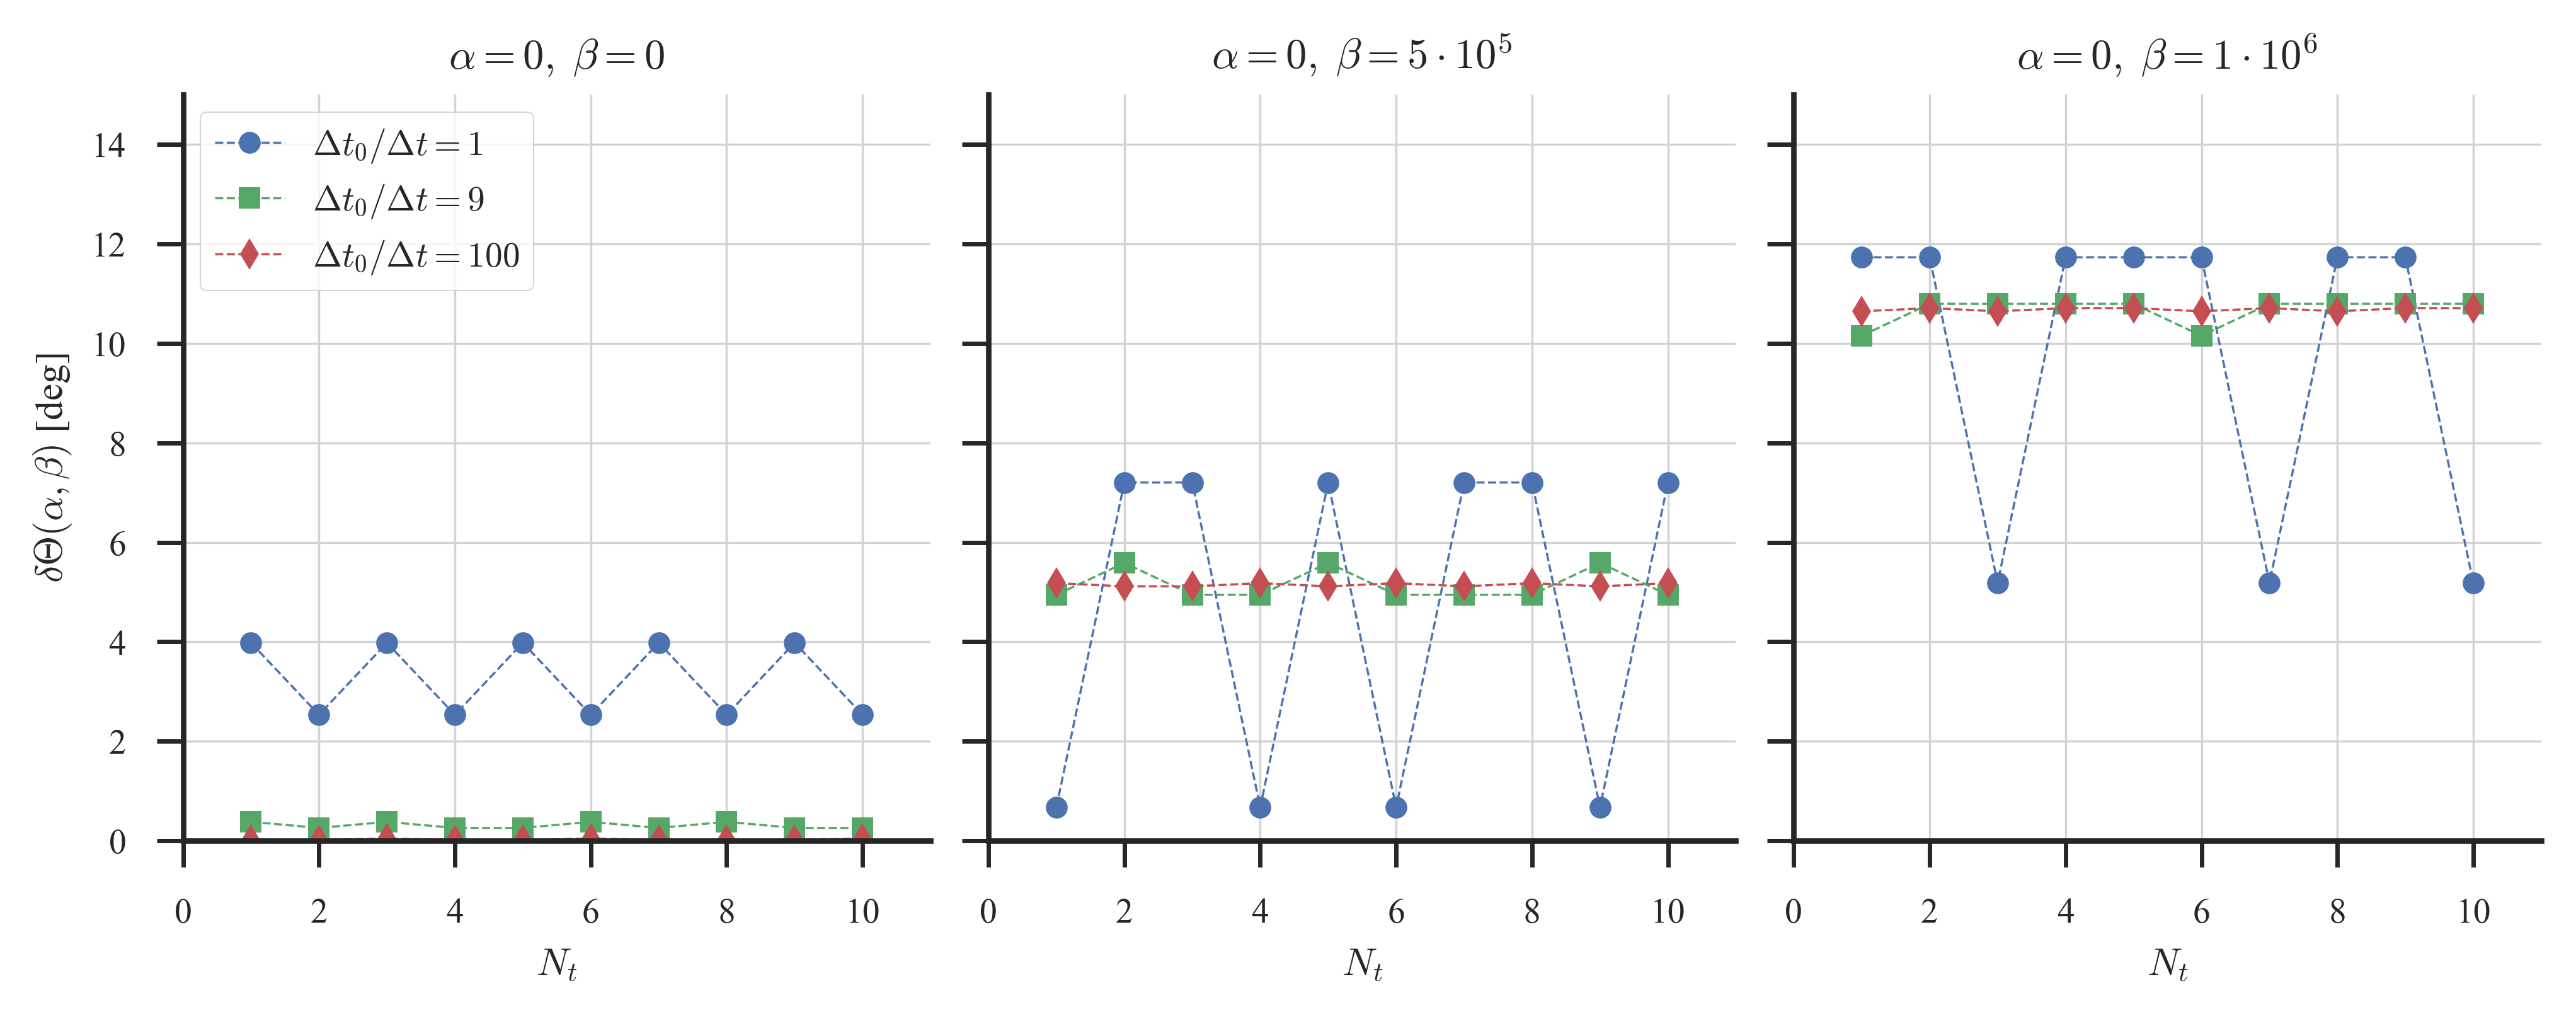

In [97]:
fig, axs = plt.subplots(figsize=(a4w, a4w/2.5), dpi=500, ncols=3, nrows=1, sharex=True, sharey=True)

ax = fig.gca()

par    ="beta"
notpar ="alpha"

markers = {
    0: "o", 1:"s", 2:"d",
}

for nax, (alpha, ax) in enumerate(zip(df[par].unique()[[0,5,10]], axs)):
    ax.set_xlabel(r"$N_t$")
    for ndt, dt in enumerate(df["dt"].unique()):
        tf = df.query("dt == @dt and {par} == @alpha and {notpar} == 0".format(par=par, notpar=notpar))
        ind = tf.index[0]
        try:
            angles = [float(val) for val in re.findall("[0-9\.]+",tf.loc[ind, "angles"])]
        except:
            angles = tf.loc[ind, "angles"]
        ax.plot(
            range(1,11),
            angles, 
            marker=markers[ndt], ms=5,
            linestyle="--", 
            lw=0.5,
            label=r"$\Delta t_0/\Delta t ={0}$".format(int(dt0/dt))
        )
        if alpha==0:
            title=r"$\{notpar} = 0, \; \{par} = 0$".format(par=par, notpar=notpar)
        else:
            title=r"$\{notpar} = 0, \; \{par} = {0:1.0e}$".format(alpha, par=par, notpar=notpar)
        
        ax.set_title(re.sub("([0-9]+)e\+0([0-9]+)","\g<1> \cdot 10^{\g<2>}",title))
        ax.grid(color='lightgray', linestyle='-', linewidth=0.5)
        ax.set_xticks([0,2,4,6,8,10])



sns.despine()

ax.set_xlim(0, 11)
ax.set_ylim(0,15)

axs[0].set_ylabel(r"$\delta \Theta(\alpha, \beta)$ [deg]")
for n in range(1,4):
    pass#plt.setp(axs[n].get_yticklabels(),visible=False)

axs[0].legend(loc="upper left", frameon=True, fontsize="small")

plt.tight_layout()

plt.show(fig)

In [98]:
fig.savefig("angular-variaton.pdf", bbox_inches="tight")

In [100]:
10.7/1.e6*3 * 3600

0.11555999999999998